In [156]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Malgun Gothic"

from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.append("../src/")

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [157]:
bnd = gpd.read_file(
    "../data/BND_ADM_DONG_PG/BND_ADM_DONG_PG.shp", 
    encoding="cp949"
    )

bnd = bnd[bnd["ADM_CD"].apply(lambda x: str(x)[0:2] == "38")]
bnd["ADM_CD"] = bnd["ADM_CD"].astype(str)
bnd["SGG_CD"] = bnd["ADM_CD"].apply(lambda x: x[0:5])

sgg_cd = [{
    "창원시 성산구" : '38112',
    "의령군" : '38510', 
    "창녕군" : '38530', 
    "고성군" : '38540', 
    "남해군" : '38550', 
    "하동군" : '38560', 
    "산청군" : '38570',
    "거창군" : '38590', 
    "합천군" : '38600', 
    "사천시" : '38060', 
    "양산시" : '38100', 
    "거제시" : '38090', 
    "김해시" : '38070', 
    "밀양시" : '38080',
    "창원시 진해구" : '38115', 
    "함양군" : '38580', 
    "창원시 의창구" : '38111', 
    "창원시 마산합포구" : '38113', 
    "창원시 마산회원구" : '38114', 
    "진주시" : '38030', 
    "통영시" : '38050',
    "함안군" : '38520'
    }]

sgg_cd = pd.DataFrame(sgg_cd).T.reset_index().rename(columns={"index" : "시군구명", 0 : "SGG_CD"})
bnd = pd.merge(bnd, sgg_cd, on="SGG_CD", how="left")
bnd = bnd.to_crs(crs="EPSG:5179")

## 노인 중심점 데이터
silver_index = pd.read_csv(
    filepath_or_buffer="../data/silver_index.csv"
)
threshold = silver_index["total_idx"].quantile(0.20)
silver_index_bot20 = silver_index[silver_index["total_idx"] <= threshold]
silver = pd.read_csv(
    filepath_or_buffer="../data/silver.csv"
).rename(columns={"gid" : "격자이름"})
silver_index_bot20 = pd.merge(left=silver_index_bot20[["격자이름", "total_idx"]], right=silver[["격자이름", "경도", "위도"]], on="격자이름", how="left")
silver_index_bot20 = gpd.GeoDataFrame(silver_index_bot20, geometry=gpd.points_from_xy(silver_index_bot20['경도'], silver_index_bot20['위도']))
silver_index_bot20 = silver_index_bot20.set_crs(crs="EPSG:4326")
silver_index_bot20 = silver_index_bot20.to_crs(epsg=5179)

## 시설 위치 데이터
facility_index = pd.read_csv(
    filepath_or_buffer="../data/facility_index.csv"
)
threshold = facility_index["total_idx"].quantile(0.20)
facility_index_bot20 = facility_index[facility_index["total_idx"] <= threshold]

facility = pd.read_csv(
    filepath_or_buffer="../data/facility.csv"
)
facility_index_bot20 = pd.merge(left=facility_index_bot20[["시설명", "total_idx"]], right=facility[["시설명", "경도", "위도"]], on="시설명", how="left")
facility_index_bot20 = gpd.GeoDataFrame(facility_index_bot20, geometry=gpd.points_from_xy(facility_index_bot20['경도'], facility_index_bot20['위도']))
facility_index_bot20 = facility_index_bot20.set_crs(crs="EPSG:4326")
facility_index_bot20 = facility_index_bot20.to_crs(epsg=5179)

## 버스 정류장 위치 데이터
busstop = pd.read_csv(
    filepath_or_buffer="../data/busstop_act.csv", 
)

## geo data 형태로 변형
busstop = gpd.GeoDataFrame(
    busstop, 
    geometry=gpd.points_from_xy(busstop['경도'], busstop['위도'])
    )

## crs값 설정
busstop = busstop.set_crs(crs="EPSG:4326")
busstop = busstop.to_crs(epsg=5179)

## 노인 중심점 데이터
silver_index_bot20_within_bnd = gpd.sjoin(
    silver_index_bot20, 
    bnd[["geometry", "ADM_NM", "ADM_CD", "시군구명"]], 
    how='inner', 
    predicate='within'
    ).drop(columns="index_right")
silver_ADM_counts = pd.DataFrame(silver_index_bot20_within_bnd.groupby('ADM_NM').size(), columns=["silver_ADM_count"])
silver_SGG_counts = pd.DataFrame(silver_index_bot20_within_bnd.groupby('시군구명').size(), columns=["silver_SGG_count"])

bnd = pd.merge(pd.merge(bnd, silver_ADM_counts, on="ADM_NM", how="left"), silver_SGG_counts, on="시군구명", how="left")
bnd[["silver_ADM_count", "silver_SGG_count"]] = bnd[["silver_ADM_count", "silver_SGG_count"]].fillna(0)

## 시설 위치 데이터
facility_index_bot20_within_bnd = gpd.sjoin(
    facility_index_bot20, 
    bnd[["geometry", "ADM_NM", "ADM_CD", "시군구명"]], 
    how='inner', 
    predicate='within'
    ).drop(columns="index_right")
facility_ADM_counts = pd.DataFrame(facility_index_bot20_within_bnd.groupby('ADM_NM').size(), columns=["facility_ADM_count"])
facility_SGG_counts = pd.DataFrame(facility_index_bot20_within_bnd.groupby('시군구명').size(), columns=["facility_SGG_count"])

bnd = pd.merge(pd.merge(bnd, facility_ADM_counts, on="ADM_NM", how="left"), facility_SGG_counts, on="시군구명", how="left")
bnd[["facility_ADM_count", "facility_SGG_count"]] = bnd[["facility_ADM_count", "facility_SGG_count"]].fillna(0)

In [192]:
# bnd.to_csv("../data/시각화데이터/bnd_count.csv", index=False)
# silver_index_bot20_within_bnd.to_csv("../data/시각화데이터/silver_index_bot20_within_bnd.csv", index=False)
# facility_index_bot20_within_bnd.to_csv("../data/시각화데이터/facility_index_bot20_within_bnd.csv", index=False)

In [193]:
# gpd.read_file("../data/시각화데이터/bnd_count.csv")
# gpd.read_file("../data/시각화데이터/silver_index_bot20_within_bnd.csv")
# gpd.read_file("../data/시각화데이터/facility_index_bot20_within_bnd.csv")

### 하위 20% 지역 확인

In [164]:
bnd.sort_values(by="silver_ADM_count", ascending=False)[["ADM_NM", "시군구명", "silver_ADM_count", "silver_SGG_count"]].head(50)

,ADM_NM,시군구명,silver_ADM_count,silver_SGG_count
233,고현면,남해군,98.0,448.0
234,설천면,남해군,94.0,448.0
232,서면,남해군,94.0,448.0
203,남지읍,창녕군,87.0,432.0
246,옥종면,하동군,78.0,513.0
240,금남면,하동군,78.0,513.0
289,산내면,밀양시,77.0,513.0
255,가야면,합천군,70.0,819.0
256,야로면,합천군,69.0,819.0
93,진전면,창원시 마산합포구,68.0,110.0


#### count가 높은 고현면 격자로 확인

In [194]:
silver_ghm = silver_index_bot20_within_bnd[silver_index_bot20_within_bnd["ADM_NM"] == "고현면"]
bnd_ghm = bnd[bnd["ADM_NM"] == "고현면"]

In [195]:
import numpy as np
from shapely import Polygon

# 격자 생성 함수 정의
def create_grid(gdf, grid_size):
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds
    rows = int(np.ceil((ymax - ymin) / grid_size))
    cols = int(np.ceil((xmax - xmin) / grid_size))
    
    x_left_origin = xmin
    x_right_origin = xmin + grid_size
    y_top_origin = ymax
    y_bottom_origin = ymax - grid_size
    polygons = []
    
    for i in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for j in range(rows):
            polygons.append(Polygon([(x_left_origin, y_top), 
                                     (x_right_origin, y_top), 
                                     (x_right_origin, y_bottom), 
                                     (x_left_origin, y_bottom)])) 
            y_top = y_top - grid_size
            y_bottom = y_bottom - grid_size
        x_left_origin = x_left_origin + grid_size
        x_right_origin = x_right_origin + grid_size

    grid = gpd.GeoDataFrame({'geometry':polygons})
    return grid

# 100m 격자 생성
grid_size = 100  # 100 meters
grid = create_grid(bnd_ghm, grid_size)

In [196]:
# 격자와 지리 데이터 병합
grid.crs = bnd_ghm.crs  # 좌표계 맞추기
grid = gpd.sjoin(grid, bnd_ghm[["geometry", "ADM_NM"]], how='inner', predicate='intersects')
grid = grid.drop(columns=["index_right"])
points_within_grid = gpd.sjoin(
    silver_ghm, 
    grid, 
    how='inner', 
    predicate='within', 
    # lsuffix='left', 
    # rsuffix='right'
    )
points_within_grid["total_idx_reverse"] = 1 / points_within_grid["total_idx"]

In [203]:
np.log(2) + np.log(5)

np.float64(2.3025850929940455)

In [204]:
np.log(7)

np.float64(1.9459101490553132)

In [168]:
# scaler = MinMaxScaler((0,1))
# points_within_grid["total_idx_reverse"] = scaler.fit_transform(points_within_grid[["total_idx_reverse"]])

In [215]:
grid_idx_sum_reverse = points_within_grid.groupby('index_right')["total_idx_reverse"].sum()
grid['idx_sum_reverse'] = grid_idx_sum_reverse
grid['idx_sum_reverse'] = grid['idx_sum_reverse'].fillna(0)

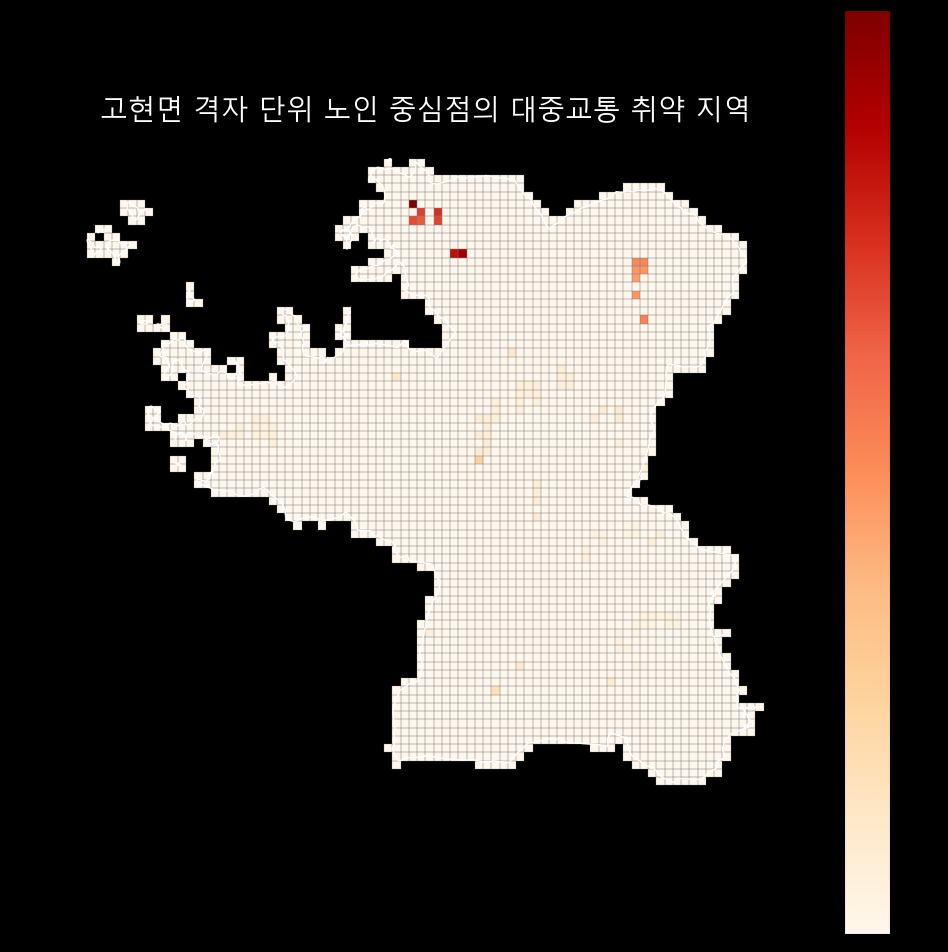

In [216]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 검은색 배경 설정 (옵션)
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# 격자별 total_idx를 컬러맵으로 시각화
grid.plot(column="idx_sum_reverse", ax=ax, legend=True, cmap="OrRd")
grid.boundary.plot(ax=ax, linewidth=0.2, color='gray')
bnd_ghm.boundary.plot(ax=ax, linewidth=1, color='white')

# 제목 설정
plt.title('고현면 격자 단위 노인 중심점의 대중교통 취약 지역', color='white', fontsize=20)  # 폰트 크기를 20으로 설정

plt.show()